**Part 1: Import Necessary Libraries**

In [1]:
# Import TensorFlow, the core library for machine learning and neural networks in Python.
import tensorflow as tf

# From tensorflow.keras.models, import the Sequential model class.
# Sequential models are a linear stack of layers, which is a common architecture for CNNs.
from tensorflow.keras.models import Sequential

# Import various layers from tensorflow.keras.layers to construct the CNN.
# Conv2D for convolutional layers that will extract features from the images.
# MaxPooling2D for pooling layers that will reduce the spatial dimensions of the output from convolutional layers.
# Flatten to convert the pooled feature map to a single column that can be input to the dense layer.
# Dense for fully connected layers that will perform classification based on the features extracted and pooled.
# Dropout for dropout layers to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Import ImageDataGenerator from tensorflow.keras.preprocessing.image.
# It's used to easily load and preprocess images in batches from directories,
# and to augment the training images for better generalization.
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Import l2 from tensorflow.keras.regularizers.
# l2 regularization penalizes large weights during training, helping to prevent overfitting.
from tensorflow.keras.regularizers import l2

# Import plot_model from tensorflow.keras.utils.
# plot_model is used to visualize the architecture of your neural network.
from tensorflow.keras.utils import plot_model

# Import Adam from tensorflow.keras.optimizers.
# Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively.
from tensorflow.keras.optimizers import Adam

# Import os to interact with the file system.
import os

# Import numpy, a fundamental package for scientific computing in Python.
# It's often used for operations on arrays, matrices, and for scientific computing.
import numpy as np

# Import pandas, a library providing high-performance, easy-to-use data structures and data analysis tools.
# It's commonly used for data manipulation and analysis.
import pandas as pd

# Import pyplot from matplotlib, a plotting library for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt


# Import the Bayesian Optimization tuner from the Keras Tuner library to  hyperparameter optimization for Keras models.
from keras_tuner.tuners import BayesianOptimization

# Checking GPU availablibility
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

**Part 2: Preparing the Data**

In [37]:
# Define paths to your data directories
# These paths are where your training, validation, and test datasets are stored on your computer.
# It's assumed that each directory contains subdirectories for each class, which in this case would be 'Normal' and 'Pneumonia'.
# Get the path of the current script
# Get the absolute path of the notebook
train_dir = r"C:\Users\sheha\Downloads\archive\chest_xray\train"
validation_dir = r"C:\Users\sheha\Downloads\archive\chest_xray\val"
test_dir = r"C:\Users\sheha\Downloads\archive\chest_xray\test"

# Initialize the data generators
# Data generators are used to load and preprocess images in batches, making it easier to feed them into the model for training or evaluation.
# This is particularly useful when working with large datasets that cannot fit into memory.
batch_size = 32  # The number of images to process in each batch.
target_size = (150, 150)  # The dimensions to which all images found will be resized. This ensures consistency in image size.

# Initialize a training data generator with data augmentation
# Data augmentation artificially increases the size of the training dataset by applying random transformations to the images,
# such as rotation, width and height shifts, shear, zoom, and horizontal flipping.
# This helps prevent overfitting and allows the model to generalize better to unseen data.
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values from [0, 255] to [0, 1] for better model performance.
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180).
    width_shift_range=0.2,  # Randomly translate images horizontally (fraction of total width).
    height_shift_range=0.2,  # Randomly translate images vertically (fraction of total height).
    shear_range=0.1,  # Randomly apply shearing transformations.
    zoom_range=0.1,  # Randomly zoom inside pictures.
    horizontal_flip=True,  # Randomly flip images horizontally.
    fill_mode='nearest'  # Strategy used for filling in newly created pixels after a rotation or width/height shift.
)

# Initialize a test data generator without data augmentation
# For validation and test datasets, you typically only apply rescaling to normalize the pixel values.
# This is because we want to evaluate the model on unaltered images.
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling is applied here.

# Prepare the training data generator
# This generator reads images from the specified directory, applies the defined preprocessing and data augmentation,
# and yields batches of images and their labels for training.
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the training data directory.
    target_size=target_size,  # Resize all images to this size.
    batch_size=batch_size,  # The size of the batches to create.
    class_mode='binary'  # Since we're doing binary classification (e.g., Normal vs. Pneumonia), labels are binary.
)

# Prepare the validation data generator
# Similar to the training generator, but for validation data. Data augmentation is not applied to validation data.
validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Path to the validation data directory.
    target_size=target_size,  # Resize all images to this size.
    batch_size=batch_size,  # The size of the batches to create.
    class_mode='binary'  # The type of label arrays to return. 'binary' indicates two possible classes.
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#Check the Data

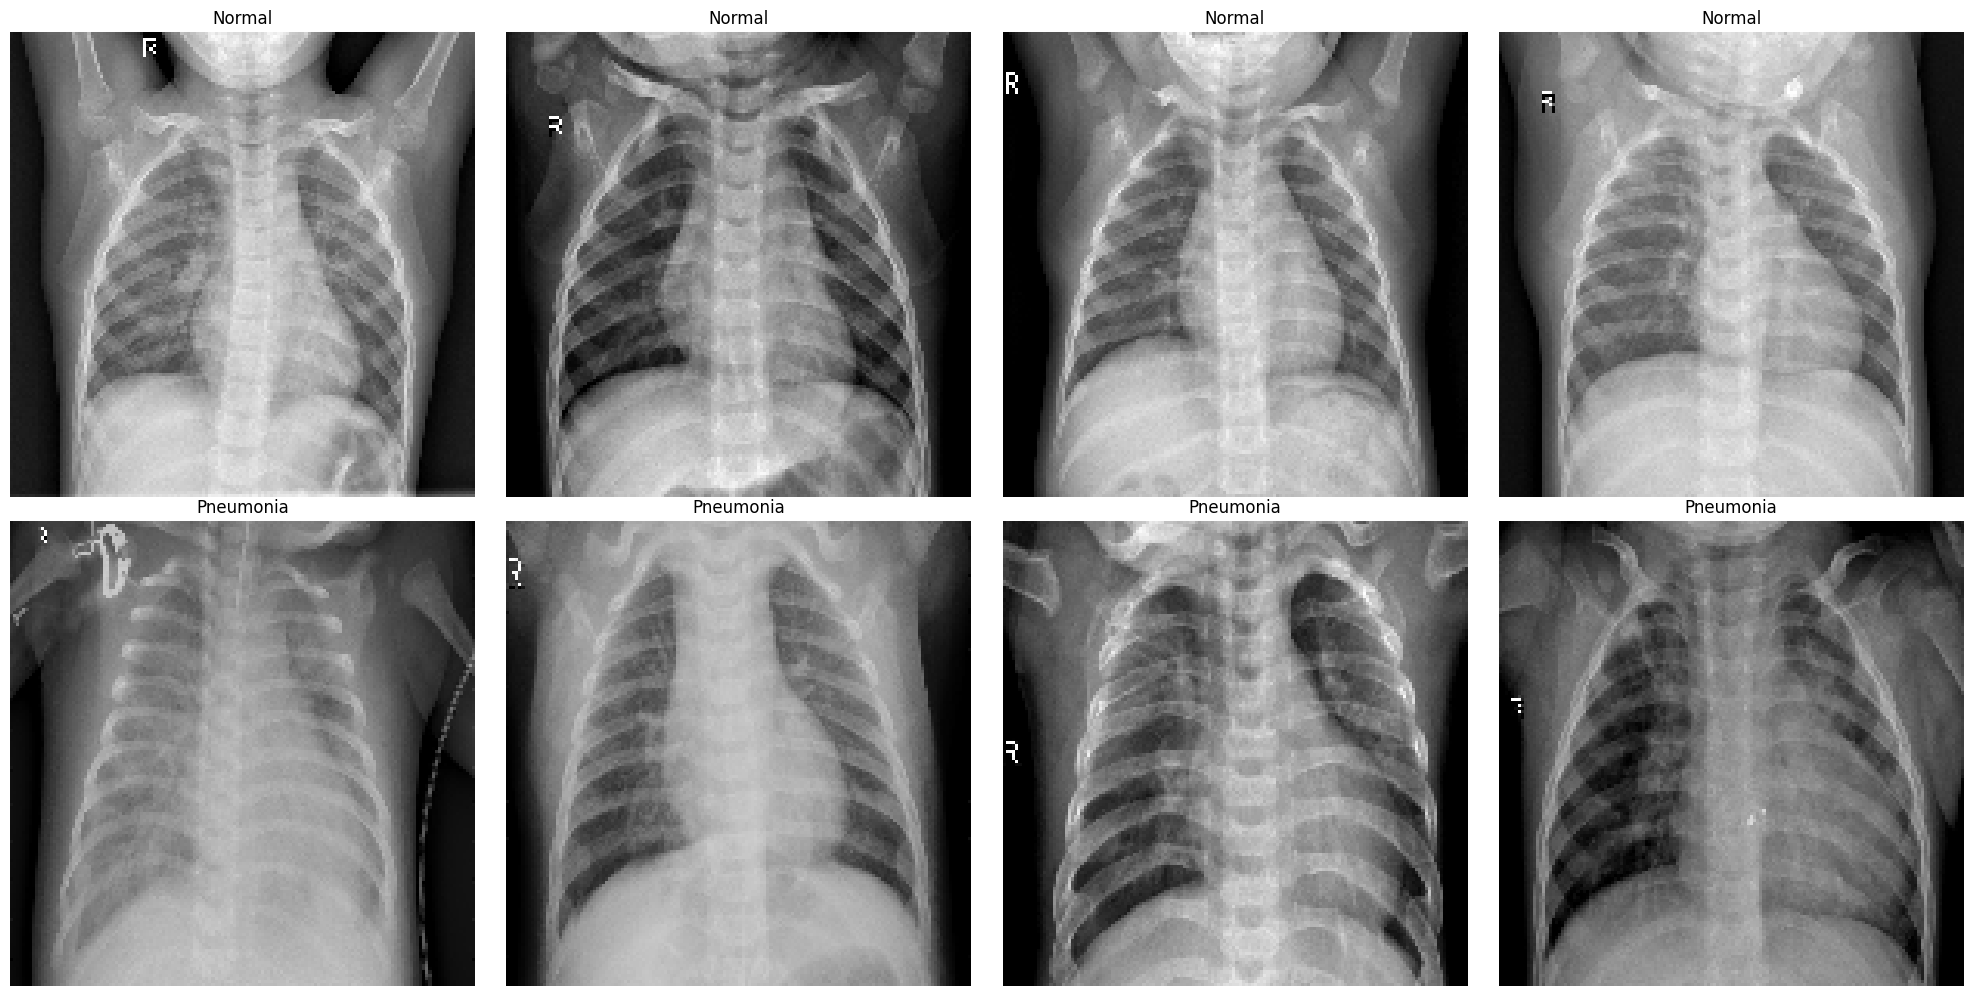

In [38]:

# Set the directory for normal and pneumonia images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Get the filenames for a few normal and pneumonia images
normal_images = os.listdir(train_normal_dir)[:4]
pneumonia_images = os.listdir(train_pneumonia_dir)[:4]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, img_name in enumerate(normal_images):
    img_path = os.path.join(train_normal_dir, img_name)
    img = load_img(img_path, target_size=(150, 150))
    axes[0, i].imshow(img)
    axes[0, i].set_title("Normal")
    axes[0, i].axis('off')

for i, img_name in enumerate(pneumonia_images):
    img_path = os.path.join(train_pneumonia_dir, img_name)
    img = load_img(img_path, target_size=(150, 150))
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [39]:
train_samples = 5216  # Number of training samples
validation_samples = 16  # Number of validation samples
batch_size = 32  # Batch size

steps_per_epoch = train_samples // batch_size
validation_steps = max(validation_samples // batch_size, 1)  # Ensure at least 1 step

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Define the input shape of the images
input_shape = (150, 150, 3)  # This is the shape of the images that the model will accept. The shape (150, 150, 3) corresponds to 150x150 pixel images with 3 color channels (RGB).

Steps per epoch: 163
Validation steps: 1


**Part 3: Building the CNN Model**

In [116]:
def create_base_model(input_shape):
    # Start a Keras Sequential model
    model = Sequential([
        # First layer: a 2D convolutional layer with 32 filters, a kernel size of 3x3, 
        # and 'relu' as the activation function. This layer will learn 32 different 
        # spatial filters and it expects an input of the specified 'input_shape'.
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        
        # Second layer: a max pooling layer with a pool size of 2x2. 
        # This serves to reduce the spatial dimensions (width and height) of the output from the previous convolutional layer.
        MaxPooling2D((2, 2)),
        
        # Third layer: another 2D convolutional layer, this time with 64 filters.
        # More filters allow the network to learn more complex patterns.
        Conv2D(64, (3, 3), activation='relu'),
        
        # Fourth layer: another max pooling layer, further reducing the spatial dimensions.
        MaxPooling2D((2, 2)),
        
        # Fifth layer: a flattening layer to convert the 2D matrix data to a 1D vector.
        # This is necessary before using fully connected layers (Dense layers).
        Flatten(),
        
        # Sixth layer: a fully connected (Dense) layer with 128 units (neurons).
        # It takes the flattened input and applies relu activation.
        Dense(128, activation='relu'),
        
        # Final layer: a Dense layer with a single neuron and a sigmoid activation function.
        # The sigmoid function outputs a value between 0 and 1, representing the probability of the input being in class 1.
        # Since this is a binary classification task, one output neuron is sufficient.
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with the Adam optimizer, binary crossentropy loss (appropriate for binary classification tasks),
    # and accuracy as the metric to track during training.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # The function returns the compiled model ready for training.
    return model

# Create the base model
base_model = create_base_model(input_shape)

**Part 4: Training the Model**

In [117]:
# Number of epochs to train the model.
# An epoch is one complete pass through the entire training dataset.
epochs = 20

# Fit the model using the training data generator.
history_base = base_model.fit(
    # train_generator is an instance of ImageDataGenerator configured for the training data.
    # It will generate batches of training data with real-time data augmentation if specified.
    train_generator,
    
    # steps_per_epoch specifies how many batch iterations the model should run before 
    # declaring one epoch finished and moving on to the next epoch.
    # It is usually the number of unique samples in your training set divided by the batch size.
    steps_per_epoch=steps_per_epoch,
    
    # epochs is the number of times the model will iterate over the entire training dataset.
    epochs=epochs,
    
    # validation_data is another instance of ImageDataGenerator, but it's configured for validation data.
    # The model will evaluate itself against this data at the end of each epoch to monitor performance on a dataset it hasn't trained on.
    validation_data=validation_generator,
    
    # validation_steps specifies how many batch iterations to run in the evaluation of the validation data.
    # Like steps_per_epoch, it's typically the number of unique validation samples divided by the validation batch size.
    validation_steps=validation_steps
)


Epoch 1/20
163/163 [==============================] - 60s 367ms/step - loss: 0.5210 - accuracy: 0.7935 - val_loss: 0.4730 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - 37s 226ms/step - loss: 0.2901 - accuracy: 0.8694 - val_loss: 0.7311 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 37s 225ms/step - loss: 0.2665 - accuracy: 0.8827 - val_loss: 0.6840 - val_accuracy: 0.6875
Epoch 4/20
163/163 [==============================] - 37s 225ms/step - loss: 0.2391 - accuracy: 0.9009 - val_loss: 0.3821 - val_accuracy: 0.8750
Epoch 5/20
163/163 [==============================] - 37s 227ms/step - loss: 0.2237 - accuracy: 0.9064 - val_loss: 0.8343 - val_accuracy: 0.6875
Epoch 6/20
163/163 [==============================] - 37s 226ms/step - loss: 0.2052 - accuracy: 0.9172 - val_loss: 1.0719 - val_accuracy: 0.6250
Epoch 7/20
163/163 [==============================] - 37s 225ms/step - loss: 0.1986 - accuracy: 0.9185 - val_loss: 0.4806 - val_ac

In [118]:
base_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 82944)             0         
                                                                 
 dense_28 (Dense)            (None, 128)             

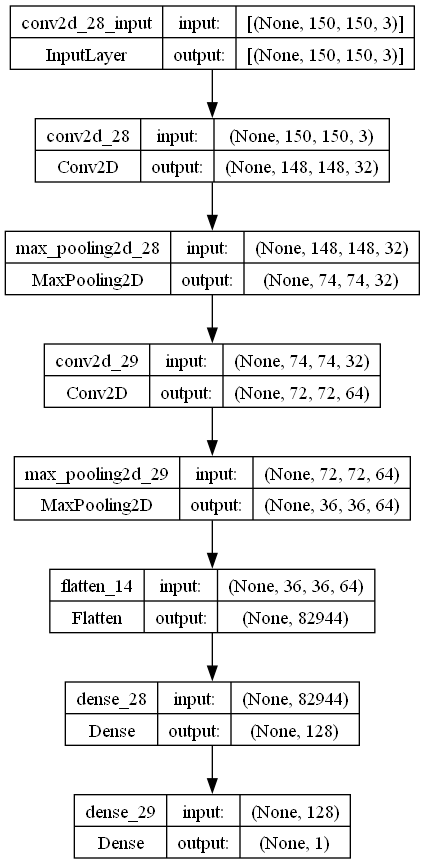

In [119]:
# Drawing the model
plot_model(base_model, to_file='base_model.png', show_shapes=True, show_layer_names=True)

**Part 5: Evaluating the Model**

In [120]:
# Prepare the test data generator
test_generator = test_datagen.flow_from_directory(
    # test_dir is the path to the directory where the test images are located.
    test_dir,
    
    # target_size resizes all the images to a specified size (150x150 pixels in this case)
    # when they are loaded. This size should match the input_shape that the model expects.
    target_size=(150, 150),
    
    # batch_size specifies how many images to process at a time.
    # The model will process batches of 20 images each during evaluation.
    batch_size=20,
    
    # class_mode='binary' is used because this is a binary classification problem.
    # The generator needs to know this so it can return labels in the binary format (0 or 1).
    class_mode='binary'
)

# Evaluate the model on the test set
test_loss, test_acc = base_model.evaluate(test_generator)
# After evaluation, the model returns the loss value & metrics values (accuracy in this case)
# for the test data.

# Print out the test accuracy and loss
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Found 624 images belonging to 2 classes.
32/32 [==============================] - 5s 152ms/step - loss: 0.3616 - accuracy: 0.8670
Test accuracy: 0.8669871687889099, Test loss: 0.3616195619106293


Model with L2 Regularization

In [45]:
def create_l2_model(input_shape):
    # Create a Sequential model. This is a linear stack of neural network layers.
    model = Sequential([
        # Add a 2D convolutional layer with 32 filters of size 3x3, using ReLU activation.
        # Apply L2 regularization with a regularization factor of 0.001 to this layer's weights.
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        
        # Add a max pooling layer that reduces the spatial dimensions by half, taking the maximum value over a 2x2 window.
        MaxPooling2D((2, 2)),
        
        # Add another convolutional layer with 64 filters and L2 regularization.
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        
        # Follow it with another max pooling layer.
        MaxPooling2D((2, 2)),
        
        # Flatten the 3D output to 1D to transition to fully connected layers.
        Flatten(),
        
        # Add a fully connected (dense) layer with 128 units and ReLU activation, with L2 regularization.
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        
        # The output layer has 1 unit with a sigmoid activation function, which is suitable for binary classification.
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with the Adam optimizer, binary crossentropy as the loss function (since this is a binary classification problem), and track accuracy as a metric.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the L2 regularized model using the predefined input shape.
l2_model = create_l2_model(input_shape)

# Train the L2 regularized model using the training data generator.
# The validation_data parameter points to the validation data generator.
# The model will train for 20 epochs and print out verbose output to show the progress.
history_l2 = l2_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)



Epoch 1/20
163/163 [==============================] - 37s 223ms/step - loss: 0.6722 - accuracy: 0.7630 - val_loss: 0.7120 - val_accuracy: 0.6875
Epoch 2/20
163/163 [==============================] - 37s 230ms/step - loss: 0.4347 - accuracy: 0.8380 - val_loss: 1.1787 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 36s 221ms/step - loss: 0.3909 - accuracy: 0.8652 - val_loss: 1.0226 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 38s 233ms/step - loss: 0.3626 - accuracy: 0.8773 - val_loss: 0.7536 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 36s 221ms/step - loss: 0.3407 - accuracy: 0.8869 - val_loss: 0.9986 - val_accuracy: 0.6250
Epoch 6/20
163/163 [==============================] - 36s 222ms/step - loss: 0.3114 - accuracy: 0.8974 - val_loss: 0.4660 - val_accuracy: 0.8750
Epoch 7/20
163/163 [==============================] - 36s 220ms/step - loss: 0.3204 - accuracy: 0.8972 - val_loss: 0.9550 - val_ac

In [46]:
l2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 82944)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

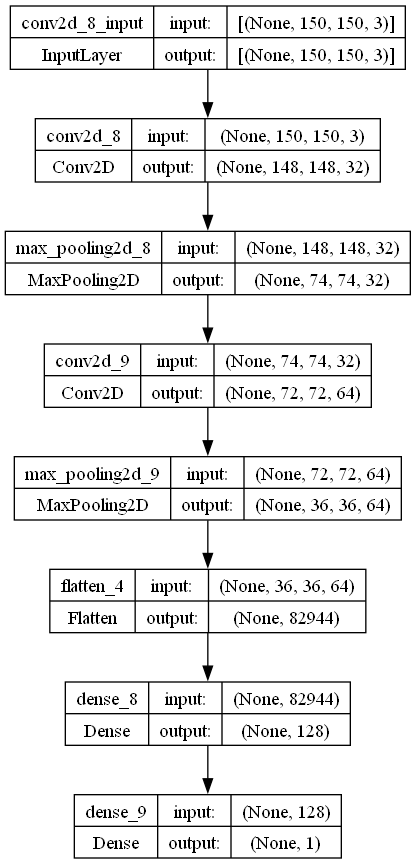

In [47]:
# Drawing the model
plot_model(l2_model, to_file='l2_model.png', show_shapes=True, show_layer_names=True)

In [48]:
# Assuming you have already defined test_datagen, which is an instance of ImageDataGenerator
# that is set up for preprocessing test data (usually just rescaling), and
# test_dir, which is the path to your test data directory.

# Prepare the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,                   # Directory where the test data is located
    target_size=(150, 150),    # The dimensions to which all images found will be resized
    batch_size=20,             # The size of the batches of data (number of images of each batch)
    class_mode='binary'        # Since it's a binary classification problem
)

# Evaluate the L2-regularized model on the test set
test_loss_l2, test_acc_l2 = l2_model.evaluate(test_generator)

# Print out the L2-regularized model's test accuracy and loss
print(f'L2-regularized Model - Test accuracy: {test_acc_l2}, Test loss: {test_loss_l2}')


Found 624 images belonging to 2 classes.
32/32 [==============================] - 3s 86ms/step - loss: 0.5188 - accuracy: 0.8093
L2-regularized Model - Test accuracy: 0.8092948794364929, Test loss: 0.518761157989502


Model with Dropout

In [121]:
def create_dropout_model(input_shape):
    # This function initializes a new Sequential model. 
    # Sequential models are a linear stack of layers.
    model = Sequential([
        # The first layer is a Conv2D layer with 32 filters of size 3x3, 
        # using the 'relu' activation function. This layer will process the input images.
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        
        # Following the convolutional layer, a MaxPooling2D layer reduces the spatial dimensions (width and height)
        # of the output from the Conv2D layer by taking the maximum value over a 2x2 pooling window.
        MaxPooling2D((2, 2)),
        
        # A Dropout layer sets a fraction (30% here) of the input units to 0 at each update during training,
        # which helps prevent overfitting.
        Dropout(0.3),
        
        # Another Conv2D layer increases the number of filters to 64, allowing the model to learn more complex patterns.
        Conv2D(64, (3, 3), activation='relu'),
        
        # This is followed by another MaxPooling2D layer, further reducing the spatial dimensions.
        MaxPooling2D((2, 2)),
        
        # Another Dropout layer again helps prevent overfitting.
        Dropout(0.2),
        
        # A Flatten layer flattens the 3D output of the previous layer to 1D, 
        # making it possible to add fully connected Dense layers after the convolutional layers.
        Flatten(),
        
        # A Dense layer with 128 units and 'relu' activation function allows the network to learn
        # non-linear combinations of the features extracted by the convolutional layers.
        Dense(128, activation='relu'),
        
        # A Dropout layer before the final output layer helps reduce overfitting by again setting 
        # a fraction (10% here) of the input units to 0.
        Dropout(0.1),
        
        # The final layer is a Dense layer with a single unit and a 'sigmoid' activation function,
        # which is suitable for binary classification. The output will be a probability indicating
        # the likelihood that the input image belongs to one of the classes.
        Dense(1, activation='sigmoid')
    ])
    
    # The model is compiled with the 'adam' optimizer (a popular choice that combines the benefits 
    # of two other extensions of stochastic gradient descent: AdaGrad and RMSProp),
    # 'binary_crossentropy' loss function (suitable for binary classification problems),
    # and will monitor 'accuracy' as the performance metric.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # The function returns the compiled model, ready for training.
    return model

# Instantiate the dropout model with the specified input shape.
dropout_model = create_dropout_model(input_shape)

# Train the dropout model using the training data generator.
# The model will also be validated using a separate validation data generator.
# Training will run for 20 epochs, and the progress for each epoch will be printed (verbose=1).
history_dropout = dropout_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)


Epoch 1/20
163/163 [==============================] - 37s 224ms/step - loss: 0.5724 - accuracy: 0.7431 - val_loss: 0.5055 - val_accuracy: 0.8750
Epoch 2/20
163/163 [==============================] - 36s 223ms/step - loss: 0.3451 - accuracy: 0.8478 - val_loss: 0.7878 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 36s 223ms/step - loss: 0.2769 - accuracy: 0.8802 - val_loss: 0.7910 - val_accuracy: 0.6875
Epoch 4/20
163/163 [==============================] - 36s 223ms/step - loss: 0.2517 - accuracy: 0.8923 - val_loss: 1.1953 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 36s 222ms/step - loss: 0.2289 - accuracy: 0.9053 - val_loss: 0.7599 - val_accuracy: 0.6875
Epoch 6/20
163/163 [==============================] - 36s 223ms/step - loss: 0.2247 - accuracy: 0.9084 - val_loss: 1.0310 - val_accuracy: 0.6250
Epoch 7/20
163/163 [==============================] - 36s 223ms/step - loss: 0.2192 - accuracy: 0.9109 - val_loss: 0.6577 - val_ac

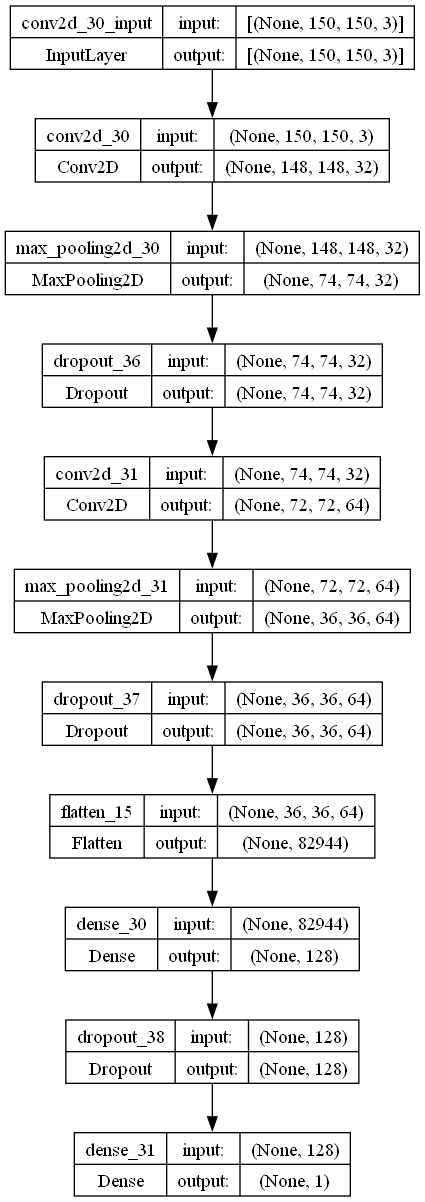

In [122]:
# Drawing the model
plot_model(dropout_model, to_file='dropout_model.png', show_shapes=True, show_layer_names=True)

In [123]:
# Assuming you have already created a test data generator named `test_generator`
# that is configured to read data from your test dataset directory with appropriate preprocessing.

# Evaluate the dropout-regularized model on the test set
test_loss_dropout, test_acc_dropout = dropout_model.evaluate(test_generator)

# Print out the dropout-regularized model's test accuracy and loss
print(f'Dropout-regularized Model - Test accuracy: {test_acc_dropout}, Test loss: {test_loss_dropout}')


32/32 [==============================] - 3s 85ms/step - loss: 0.3135 - accuracy: 0.8862
Dropout-regularized Model - Test accuracy: 0.8862179517745972, Test loss: 0.31352922320365906


# Step 4: Comparing Models

BASE Model


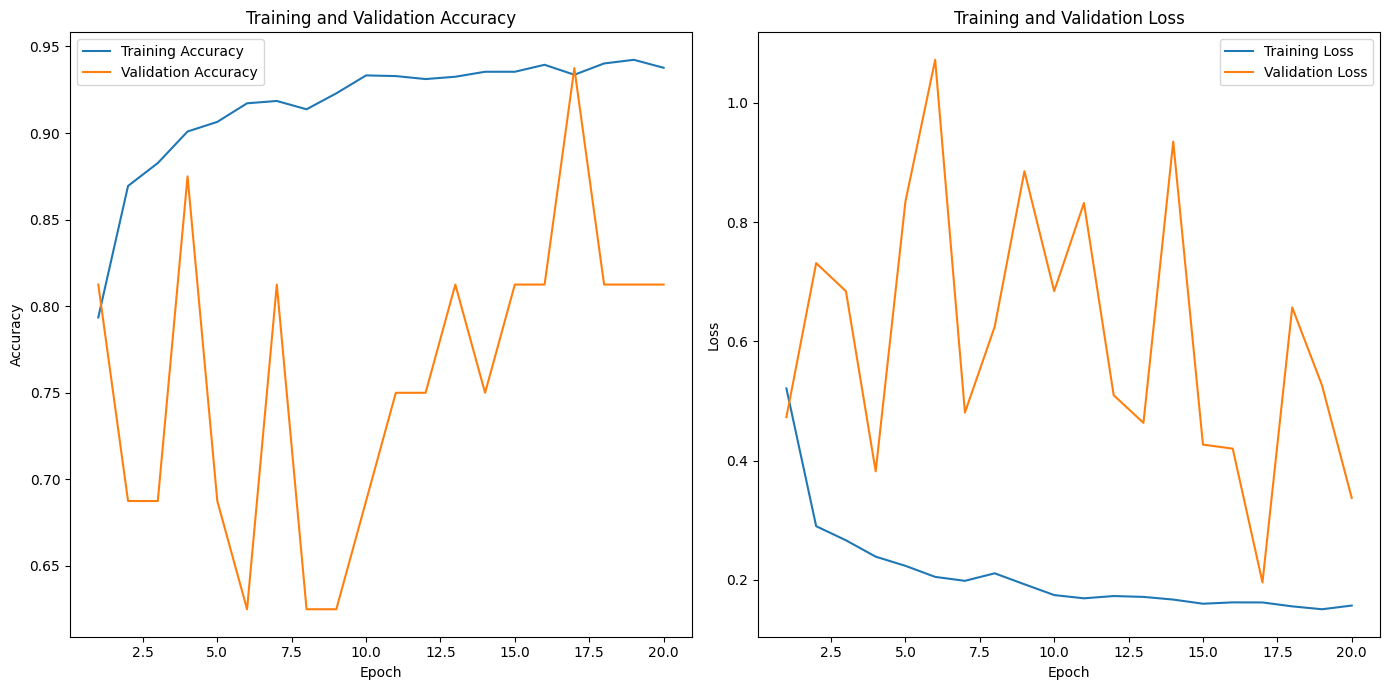

l2 Model


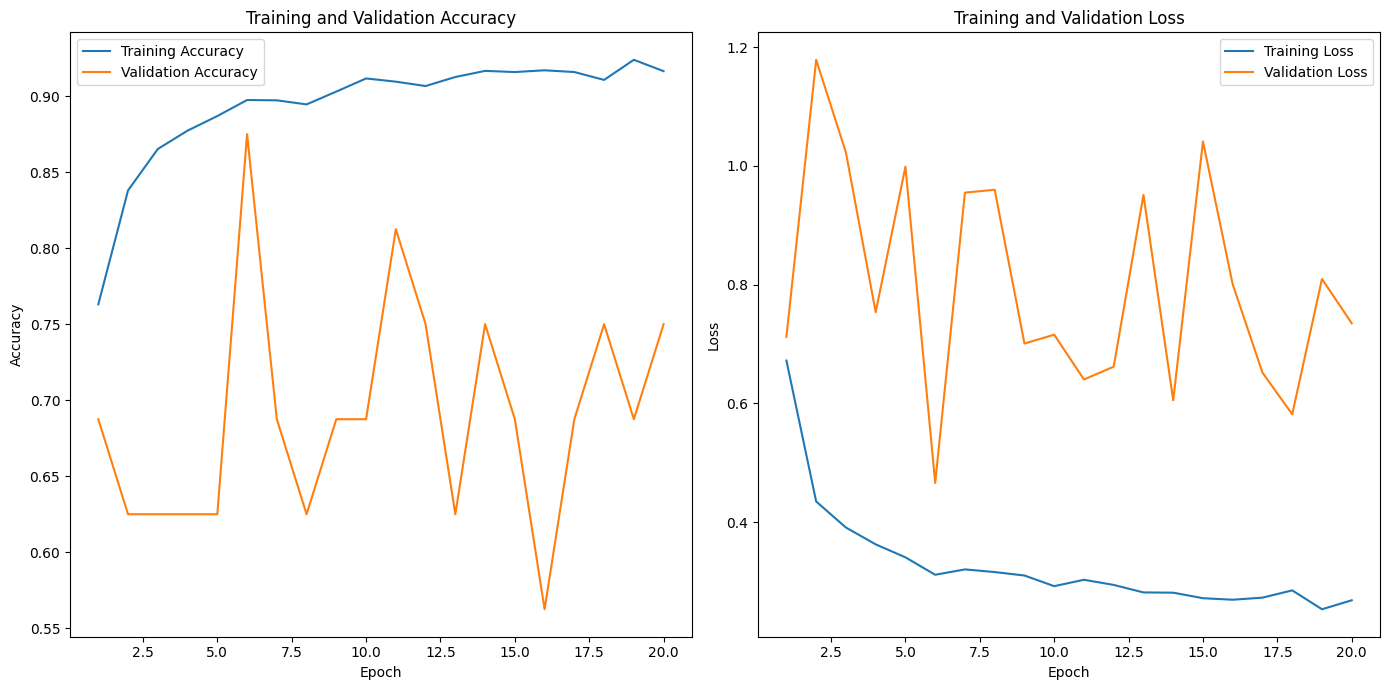

Dropout Model


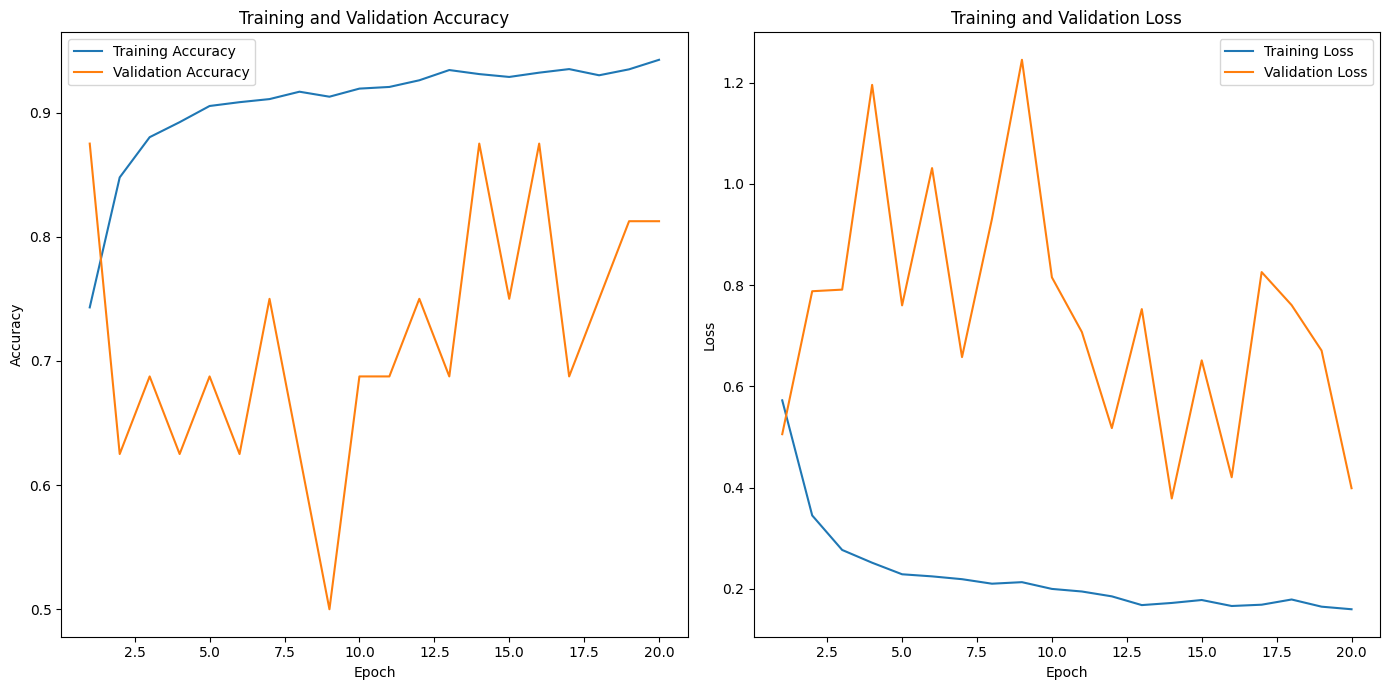

In [124]:
# Assuming 'history' is the history object returned by the 'fit' method for your model
# and it contains the training and validation metrics history.

def plot_loss_vs_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history of your model
print('BASE Model')
plot_loss_vs_accuracy(history_base)
print('l2 Model')
plot_loss_vs_accuracy(history_l2)
print('Dropout Model')
plot_loss_vs_accuracy(history_dropout)



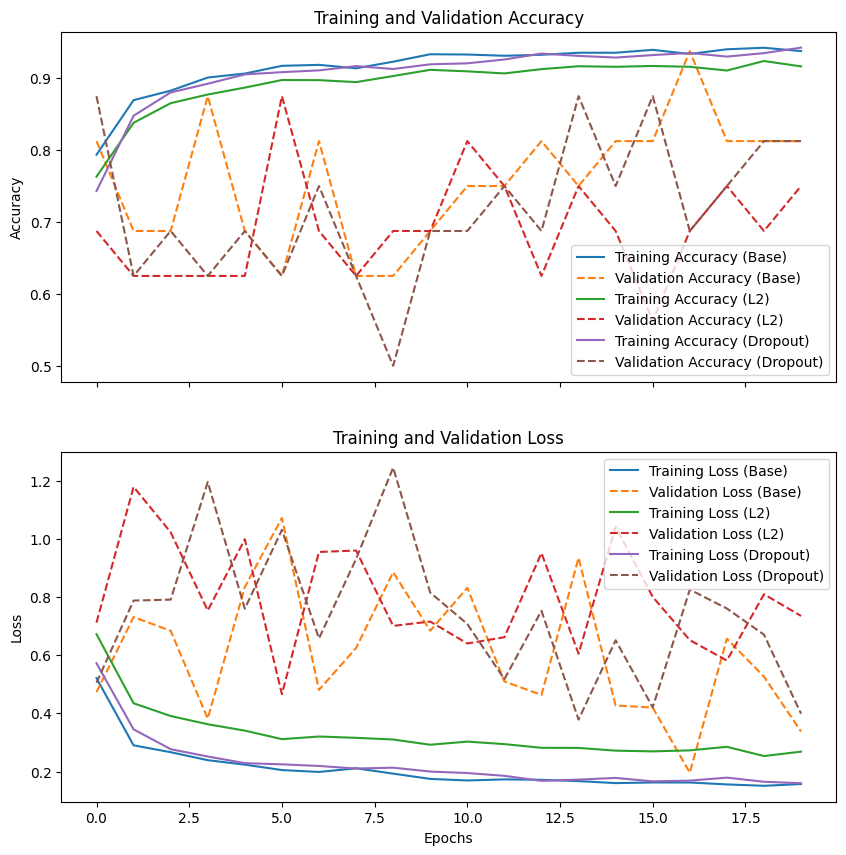

In [125]:
# Function to plot training and validation accuracy vs loss
def plot_loss_vs_accuracy(histories, titles):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot accuracy
    for history, title in zip(histories, titles):
        axs[0].plot(history.history['accuracy'], label=f'Training Accuracy ({title})')
        axs[0].plot(history.history['val_accuracy'], label=f'Validation Accuracy ({title})', linestyle='--')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].set_title('Training and Validation Accuracy')

    # Plot loss
    for history, title in zip(histories, titles):
        axs[1].plot(history.history['loss'], label=f'Training Loss ({title})')
        axs[1].plot(history.history['val_loss'], label=f'Validation Loss ({title})', linestyle='--')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    axs[1].set_title('Training and Validation Loss')

    plt.show()

# Assuming history_base, history_l2, history_dropout are the history objects of your trained models
plot_loss_vs_accuracy([history_base, history_l2, history_dropout], ['Base', 'L2', 'Dropout'])


In [126]:
# Evaluate the base model
test_loss_base, test_accuracy_base = base_model.evaluate(test_generator)

# Evaluate the L2 regularization model
test_loss_l2, test_accuracy_l2 = l2_model.evaluate(test_generator)

# Evaluate the dropout model
test_loss_dropout, test_accuracy_dropout = dropout_model.evaluate(test_generator)


32/32 [==============================] - 3s 84ms/step - loss: 0.3135 - accuracy: 0.8862


In [127]:
# Store metrics in a dictionary for easier comparison
model_performance = {
    'Model': ['Base', 'L2 Regularization', 'Dropout'],
    'Test Loss': [test_loss_base, test_loss_l2, test_loss_dropout],
    'Test Accuracy': [test_accuracy_base, test_accuracy_l2, test_accuracy_dropout]
}
# Convert the dictionary to a DataFrame for a tabular representation
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame as a table
performance_df

,Model,Test Loss,Test Accuracy
0,Base,0.361620,0.866987
1,L2 Regularization,0.518761,0.809295
2,Dropout,0.313529,0.886218


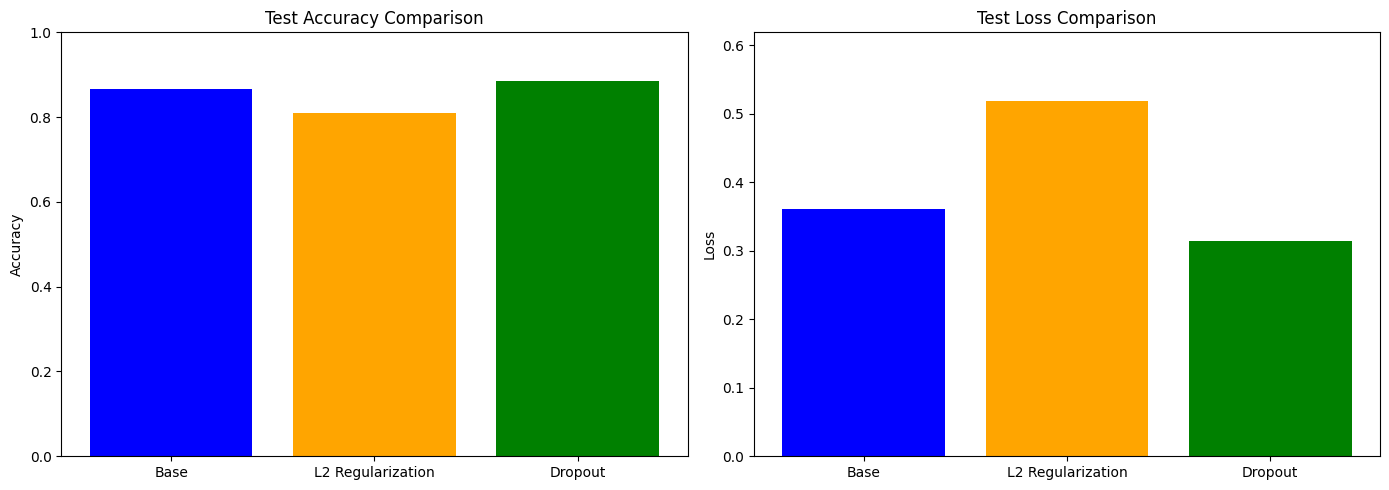

In [128]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(14, 5))

# Plot test accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.bar(model_performance['Model'], model_performance['Test Accuracy'], color=['blue', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Plot test loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.bar(model_performance['Model'], model_performance['Test Loss'], color=['blue', 'orange', 'green'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.ylim(0, max(model_performance['Test Loss']) + 0.1)  # Adjust y-axis to show all bars clearly

plt.tight_layout()
plt.show()


## HyperParameter Tuning

### Bayesian Optimization for CNN Hyperparameter Tuning and Model Creation

This section demonstrates the use of Bayesian Optimization technique for hyperparameter tuning 
and the creation of a convolutional neural network (CNN) model with dropout layers for image classification tasks.

Bayesian Optimization is a powerful method for efficiently searching the hyperparameter space of machine learning models to find the combination that optimizes a specified objective function. In this case, the objective function is the validation accuracy of the CNN model.

The 'create_dropout_model' function defines a CNN architecture with customizable hyperparameters such as the number of filters in Conv2D layers, dropout rates, and learning rate. These hyperparameters are tuned using the BayesianOptimization class provided by the Keras Tuner library.

After defining the model architecture, the BayesianOptimization instance 'tuner' is created with the 'create_dropout_model' function as the search space. The 'search' method then performs the hyperparameter search using the specified training and validation data generators, and the 'get_best_hyperparameters' method retrieves the best set of hyperparameters found during the search.

The resulting best hyperparameters can be used to train the final CNN model, providing an optimized configuration for achieving high accuracy in image classification tasks.

In [181]:
def create_dropout_model(hp):
    """
    Creates and compiles a dropout model with customizable parameters.

    Parameters:
    - hp: HyperParameters object containing the hyperparameters to be tuned.

    Returns:
    - model: Compiled Keras model.

    Hyperparameters to be tuned:
    - filters: Number of filters for Conv2D layers.
    - dropout_1: Dropout rate after the first MaxPooling2D layer.
    - dropout_2: Dropout rate after the second MaxPooling2D layer.
    - dropout_3: Dropout rate before the final Dense layer.
    - learning_rate: Learning rate for the optimizer.
    """
    model = Sequential()
    
    # Define the number of filters for Conv2D layers
    hp_filters = hp.Int('filters', min_value=32, max_value=256, step=32)

    # First Conv2D layer
    model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))

    # First Dropout layer
    hp_dropout_1 = hp.Float('dropout_1', 0.01, 0.7, step=0.01)
    model.add(Dropout(hp_dropout_1))

    # Second Conv2D layer
    model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Second Dropout layer
    hp_dropout_2 = hp.Float('dropout_2', 0.01, 0.7, step=0.01)
    model.add(Dropout(hp_dropout_2))

    # Flatten layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(128, activation='relu'))

    # Third Dropout layer
    hp_dropout_3 = hp.Float('dropout_3', 0.01, 0.7, step=0.01)      
    model.add(Dropout(hp_dropout_3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=(0.1,0.01, 0.001, 0.0001))
    optimizer_ = Adam(learning_rate=hp_learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [182]:
# Instantiate Bayesian Optimization tuner
tuner = BayesianOptimization(
    create_dropout_model,
    objective='val_loss', # Objective to optimize
    max_trials=40 # Number of search trials
    )

In [183]:
# Perform hyperparameter search

tuner.search(
    train_generator, # Data generator for training
    epochs=20, # Number of epochs for each trial
    validation_data=validation_generator, # Data generator for validation
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=4)] # Early stopping callback to prevent overfitting
    )

Trial 40 Complete [00h 08m 45s]
val_loss: 0.37407970428466797

Best val_loss So Far: 0.265316903591156
Total elapsed time: 04h 36m 14s


In [184]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0].values
print(best_hyperparameters)

{'filters': 128, 'dropout_1': 0.32, 'dropout_2': 0.62, 'dropout_3': 0.19, 'learning_rate': 0.001}


### Final Model Creation and Testing

This code segment focuses on creating, training, and evaluating the final Convolutional Neural Network (CNN) model for image classification. 

It begins by constructing the final model using the best hyperparameters determined during hyperparameter tuning. These hyperparameters include the number of filters for Conv2D layers, dropout rates, and the learning rate for the optimizer. 

The model is then compiled and trained on the training data using the fit method.

Subsequently, the trained model's performance is evaluated on the validation data to monitor its generalization ability. 

Finally, the model's performance is assessed on an unseen test dataset, and both accuracy and loss metrics are reported. 

In [185]:
def create_final_model(best_hyperparameters):
    """
    Creates and compiles the final CNN model with the best hyperparameters found during hyperparameter tuning.

    Parameters:
    - best_hyperparameters: Dictionary containing the best hyperparameters obtained from hyperparameter tuning.

    Returns:
    - model: Compiled Keras model.

    Hyperparameters to be used:
    - filters: Number of filters for Conv2D layers.
    - dropout_1: Dropout rate after the first MaxPooling2D layer.
    - dropout_2: Dropout rate after the second MaxPooling2D layer.
    - dropout_3: Dropout rate before the final Dense layer.
    - learning_rate: Learning rate for the optimizer.
    """
    model = Sequential()
    
    # Define the number of filters for Conv2D layers
    hp_filters = best_hyperparameters.get('filters')

    # First Conv2D layer
    model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))

    # First Dropout layer
    hp_dropout_1 = best_hyperparameters.get('dropout_1')
    model.add(Dropout(hp_dropout_1))

    # Second Conv2D layer
    model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Second Dropout layer
    hp_dropout_2 = best_hyperparameters.get('dropout_2')
    model.add(Dropout(hp_dropout_2))

    # Flatten layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(128, activation='relu'))

    # Third Dropout layer
    hp_dropout_3 = best_hyperparameters.get('dropout_3')    
    model.add(Dropout(hp_dropout_3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate for the optimizer
    hp_learning_rate = best_hyperparameters.get('learning_rate')
    optimizer_ = Adam(learning_rate=hp_learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [194]:
# Training the Final Model

"""
This section of the code trains the final CNN model created using the best hyperparameters obtained from hyperparameter tuning.

Parameters:
- train_generator: Generator object providing batches of training data.
- validation_generator: Generator object providing batches of validation data.
- epochs: Number of epochs for training the model.
- verbose: Verbosity mode set as 1 , which is progress bar

Returns:
- history_final_model: History object containing training and validation metrics.

The 'fit' method is used to train the model on the provided training data and evaluate it on the validation data.
The training progresses for the specified number of epochs, and training/validation metrics are recorded in the 
'history_final_model' object, which can be used for further analysis and visualization.
"""
final_model = create_final_model(best_hyperparameters)

history_final_model = final_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    verbose=1
)

Epoch 1/40
163/163 [==============================] - 42s 252ms/step - loss: 0.6090 - accuracy: 0.7372 - val_loss: 0.6287 - val_accuracy: 0.8750
Epoch 2/40
163/163 [==============================] - 39s 240ms/step - loss: 0.3934 - accuracy: 0.8081 - val_loss: 0.9536 - val_accuracy: 0.7500
Epoch 3/40
163/163 [==============================] - 38s 235ms/step - loss: 0.3204 - accuracy: 0.8560 - val_loss: 0.8034 - val_accuracy: 0.6250
Epoch 4/40
163/163 [==============================] - 39s 236ms/step - loss: 0.3000 - accuracy: 0.8744 - val_loss: 0.4640 - val_accuracy: 0.8125
Epoch 5/40
163/163 [==============================] - 39s 236ms/step - loss: 0.2629 - accuracy: 0.8859 - val_loss: 0.6598 - val_accuracy: 0.8125
Epoch 6/40
163/163 [==============================] - 39s 236ms/step - loss: 0.2585 - accuracy: 0.8898 - val_loss: 0.5628 - val_accuracy: 0.8125
Epoch 7/40
163/163 [==============================] - 38s 235ms/step - loss: 0.2473 - accuracy: 0.8949 - val_loss: 0.5792 - val_ac

In [195]:
# Evaluating the Final Model on the Test Set

"""
This section of the code evaluates the final CNN model (dropout with hyperparameter tuning) on the test set.

Parameters:
- test_generator: Generator object providing batches of test data.

Returns:
- test_loss_dropout: Loss value on the test set.
- test_acc_dropout: Accuracy value on the test set.

"""

# Evaluate the dropout-regularized model on the test set
test_loss_dropout, test_acc_dropout = final_model.evaluate(test_generator)

# Print out the dropout-regularized model's test accuracy and loss
print(f'Final Model - Test accuracy: {test_acc_dropout}, Test loss: {test_loss_dropout}')


32/32 [==============================] - 3s 87ms/step - loss: 0.3318 - accuracy: 0.8622
Final Model - Test accuracy: 0.8621794581413269, Test loss: 0.3317682445049286
